0807

# 과적합 해결

In [52]:
import torch
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import DataLoader, random_split  # dataloder : 주어진 데이터단위를 미니배치 단위로 묶어주는 유틸리티. randomsplit : 데이터셋을 학습, 테스트용으로 분리해주는 유틸리티
import torchvision.transforms as transforms            # torchvision은 이미지 처리 - 스케일링, 정규화 기능 제공(transforms)
import torchvision.datasets as datasets                # 자주쓰이는 이미지 데이터를 불러올수 있게 해주는 모듈

### 배치 정규화 적용

In [53]:
transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5, ))])  # transforms.ToTensor() 이미지를 컴퓨터가 알아들을수있게 tensor로 변환 / Normalize((0.5), (0.5, ): 해당 사이즈로 변환
dataset = datasets.MNIST(root='./data', train=True, transform=transforms, download=True)  #datasets에서 MNIST를 불러오게 하는 것. /train : 학습용 데이터셋 로드 (f가 기본) / transform=transforms 전처리를 위의 방식으로 해서 가져와라 / download=True 다운로드 해라 

In [54]:
train_size = int(0.8*len(dataset))    # 80%의 train 사이즈 
val_size = len(dataset) - train_size

train_data, val_data = random_split(dataset, [train_size, val_size])   # 검증에 나눠서 쓰기 위해 테스트 데이터 나누기 
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)     # 하위 데이터셋을 미니배치(batch) 단위로 꺼내올 수 있게 만들어 주는 유틸리티
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)          

In [55]:
# BatchNorm1d를 사용하는 신경망 구조 

class SimpleNN(nn.Module) :
    def __init__(self, use_bn=False):   #use_bn: 배치 정규화를 적용하는지 
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.bn1 = nn.BatchNorm1d(128) if use_bn else nn.Identity()
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64) if use_bn else nn.Identity()
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):   # 소프트 맥스 함수 처리를 해주기 때문에 return에 소프트맥스 안함. 
        x = x.view(x.size(0), -1)  # (배치크기, h, w) -> (배치크기, feature)
        x = torch.relu(self.bn1(self.fc1(x)))
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)

        return x

In [56]:
def train(model, train_loader, val_loader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader :            # 미니배치로 뽑은 데이터의 x, y값 
            images = images.view(images.size(0), -1)    # 평탄화
            optimizer.zero_grad()                       # 기울기 초기화 
            outputs = model(images)                     # 순전파의 결과값
            loss = criterion(outputs, labels)           # 손실값
            loss.backward()                             # 역전파 
            optimizer.step()                            # 가중치 업데이트 
            
        model.eval()
        val_loss = 0 
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader : 
                images = images.view(images.size(0), -1)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()

        print(f'Epoch { epoch +1} | Val Loss : { val_loss / len(val_loader):.4f}, Accuracy: { correct / len(val_data):.4f}')

In [58]:
print('배치 정규화 적용 안함')
model_without_bn = SimpleNN(use_bn = False)
train(model_without_bn, train_loader, val_loader)

print()
print('배치 정규화 적용')
model_with_bn = SimpleNN(use_bn = True)
train(model_with_bn, train_loader, val_loader)  # 배치 정규화를 쓴것이 더 잘 나옴. 

배치 정규화 적용 안함
Epoch 1 | Val Loss : 0.2450, Accuracy: 0.9253
Epoch 2 | Val Loss : 0.1738, Accuracy: 0.9456
Epoch 3 | Val Loss : 0.1419, Accuracy: 0.9549
Epoch 4 | Val Loss : 0.1273, Accuracy: 0.9607
Epoch 5 | Val Loss : 0.1149, Accuracy: 0.9653

배치 정규화 적용
Epoch 1 | Val Loss : 0.1288, Accuracy: 0.9620
Epoch 2 | Val Loss : 0.0910, Accuracy: 0.9730
Epoch 3 | Val Loss : 0.0962, Accuracy: 0.9710
Epoch 4 | Val Loss : 0.0903, Accuracy: 0.9735
Epoch 5 | Val Loss : 0.0864, Accuracy: 0.9742


In [ ]:
for batch_size in [16, 32, 128] : 
    print(f'batch size: { batch_size}')
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    model = SimpleNN(use_bn = True)
    train(model, train_loader, val_loader)   # 배치사이즈가 커지면 튀는 다이나믹함을 볼 수 있음. 

batch size: 16
Epoch 1 | Val Loss : 0.1208, Accuracy: 0.9627
Epoch 2 | Val Loss : 0.1011, Accuracy: 0.9681
Epoch 3 | Val Loss : 0.0916, Accuracy: 0.9721
Epoch 4 | Val Loss : 0.0896, Accuracy: 0.9737
Epoch 5 | Val Loss : 0.0796, Accuracy: 0.9768
batch size: 32
Epoch 1 | Val Loss : 0.1222, Accuracy: 0.9647
Epoch 2 | Val Loss : 0.0899, Accuracy: 0.9732
Epoch 3 | Val Loss : 0.0844, Accuracy: 0.9744
Epoch 4 | Val Loss : 0.0811, Accuracy: 0.9759
Epoch 5 | Val Loss : 0.0789, Accuracy: 0.9778
batch size: 128
Epoch 1 | Val Loss : 0.1432, Accuracy: 0.9603
Epoch 2 | Val Loss : 0.1035, Accuracy: 0.9682
Epoch 3 | Val Loss : 0.0910, Accuracy: 0.9723
Epoch 4 | Val Loss : 0.0857, Accuracy: 0.9755
Epoch 5 | Val Loss : 0.0939, Accuracy: 0.9725


### 드롭아웃 적용

In [ ]:
class DropoutNN(nn.Module) :
    def __init__(self, dropout_rate) :
        super(DropoutNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x) : 
        x = x.view(x.size(0), -1)
        x = torch.relu(self.dropout1(self.fc1(x)))  # 훈련상황에서만 작동 
        x = torch.relu(self.dropout2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [ ]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

for rate in [0.2, 0.5, 0.8] : 
    print(f'Dropout Rate: {rate}')
    model = DropoutNN(dropout_rate=rate)
    train(model, train_loader, val_loader)

Dropout Rate: 0.2
Epoch 1 | Val Loss : 0.2328, Accuracy: 0.9320
Epoch 2 | Val Loss : 0.1878, Accuracy: 0.9450
Epoch 3 | Val Loss : 0.1516, Accuracy: 0.9544
Epoch 4 | Val Loss : 0.1398, Accuracy: 0.9577
Epoch 5 | Val Loss : 0.1333, Accuracy: 0.9614
Dropout Rate: 0.5
Epoch 1 | Val Loss : 0.3414, Accuracy: 0.8981
Epoch 2 | Val Loss : 0.2858, Accuracy: 0.9178
Epoch 3 | Val Loss : 0.2689, Accuracy: 0.9246
Epoch 4 | Val Loss : 0.2628, Accuracy: 0.9218
Epoch 5 | Val Loss : 0.2285, Accuracy: 0.9363
Dropout Rate: 0.8
Epoch 1 | Val Loss : 1.4268, Accuracy: 0.6165
Epoch 2 | Val Loss : 1.2488, Accuracy: 0.6253
Epoch 3 | Val Loss : 1.2724, Accuracy: 0.6152
Epoch 4 | Val Loss : 1.2045, Accuracy: 0.6440
Epoch 5 | Val Loss : 1.3222, Accuracy: 0.6168


In [ ]:
model = DropoutNN(dropout_rate=0.2)

In [ ]:
model.eval()  # 모든 뉴런 활성화
with torch.no_grad():
    images, _ = next(iter(val_loader))         # 미니배치에서 하나만 꺼내는 것 
    images = images.view(images.size(0), -1)   

    out1 = model(images)
    out2 = model(images)

    print(torch.allclose(out1, out2))          # 두개의 텐서값이 유사한지 비교하는 것 

# test 에서는 dropout이 동작하지 않아서 동일한 뉴런에 대해 통과하기 때문에 두가지 텐서값이 유사함. 

True


In [ ]:
model.train()

out1 = model(images)    # 드롭아웃이 적용됐기 때문에 학습데이터에서는 False 반환. 각자 다른 뉴런을 통과해서 다른 값 반환
out2 = model(images)

print(torch.allclose(out1, out2))  # 드롭아웃이 학습과정에서 다른 뉴런을 통과 시킨다는 것을 알 수 있다. 

False


### Learning Rate Scheduler 적용

In [ ]:
class RealSimpleNN(nn.Module) : 
    def __init__(self) :
        super(RealSimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x 

In [ ]:
def train_lr(model, train_loader, val_loader, optimizer, scheduler, epochs=10):
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader :            # 미니배치로 뽑은 데이터의 x, y값 
            images = images.view(images.size(0), -1)    # 평탄화
            optimizer.zero_grad()                       # 기울기 초기화 
            outputs = model(images)                     # 순전파의 결과값
            loss = criterion(outputs, labels)           # 손실값
            loss.backward()                             # 역전파 
            optimizer.step()                            # 가중치 업데이트 
            
        model.eval()
        val_loss = 0 
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader : 
                images = images.view(images.size(0), -1)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()

        scheduler.step()
        print(f'Epoch { epoch +1} | Val Loss : { val_loss / len(val_loader):.4f}, Accuracy: { correct / len(val_data):.4f}')

In [ ]:
model = RealSimpleNN()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

train_lr(model, train_loader, val_loader, optimizer, scheduler)

Epoch 1 | Val Loss : 0.2656, Accuracy: 0.9189
Epoch 2 | Val Loss : 0.2397, Accuracy: 0.9315
Epoch 3 | Val Loss : 0.2927, Accuracy: 0.9240
Epoch 4 | Val Loss : 0.1658, Accuracy: 0.9533
Epoch 5 | Val Loss : 0.1549, Accuracy: 0.9551


### 조기 종료 

In [60]:
def train_es(model, train_loader, val_loader, optimizer, epochs=50, early_stopping=None):
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0 
        for images, labels in train_loader :
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad() :
            for images, labels in val_loader :
                images = images.view(images.size(0), -1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim =1)
                correct += (preds == labels).sum().item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        accuracy = correct / len(val_data)

        print(f'Epoch { epoch +1} | Val Loss : { val_loss:.4f}, Accuracy: { accuracy:.4f}')

        if early_stopping and early_stopping(val_loss):
            print(f'조기종료 epoch {epoch + 1}')
            break

    return train_losses, val_losses 


In [63]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001) :
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def __call__(self, val_loss) : 
        if val_loss < self.best_loss - self.min_delta :
            self.best_loss = val_loss
            self.counter = 0
        else : 
            self.counter += 1
        
        return self.counter >= self.patience 

In [64]:
model_no_es = RealSimpleNN()
optim_no_es = optim.Adam(model_no_es.parameters(), lr=0.1)
train_losses, val_losses = train_es(model_no_es, train_loader, val_loader, optim_no_es)

model_es = RealSimpleNN()
optim_es = optim.Adam(model_es.parameters(), lr=0.01)
early_stopping = EarlyStopping(patience=5)
train_es_losses, val_es_losses = train_es(model_es, train_loader, val_loader, optim_es, early_stopping=early_stopping)

Epoch 1 | Val Loss : 1.7732, Accuracy: 0.2926
Epoch 2 | Val Loss : 1.8876, Accuracy: 0.2335
Epoch 3 | Val Loss : 2.1993, Accuracy: 0.1587
Epoch 4 | Val Loss : 2.2994, Accuracy: 0.1102
Epoch 5 | Val Loss : 2.3067, Accuracy: 0.1003
Epoch 6 | Val Loss : 2.3178, Accuracy: 0.1023
Epoch 7 | Val Loss : 2.3066, Accuracy: 0.1019
Epoch 8 | Val Loss : 2.3144, Accuracy: 0.1019
Epoch 9 | Val Loss : 2.3151, Accuracy: 0.1102
Epoch 10 | Val Loss : 2.3060, Accuracy: 0.1019
Epoch 11 | Val Loss : 2.3043, Accuracy: 0.1045
Epoch 12 | Val Loss : 2.3118, Accuracy: 0.1045
Epoch 13 | Val Loss : 2.3103, Accuracy: 0.1102
Epoch 14 | Val Loss : 2.3090, Accuracy: 0.1102
Epoch 15 | Val Loss : 2.3083, Accuracy: 0.1035
Epoch 16 | Val Loss : 2.3052, Accuracy: 0.1102
Epoch 17 | Val Loss : 2.3076, Accuracy: 0.0936
Epoch 18 | Val Loss : 2.3066, Accuracy: 0.0995
Epoch 19 | Val Loss : 2.3058, Accuracy: 0.1001
Epoch 20 | Val Loss : 2.3096, Accuracy: 0.1019
Epoch 21 | Val Loss : 2.3145, Accuracy: 0.1022
Epoch 22 | Val Loss : 

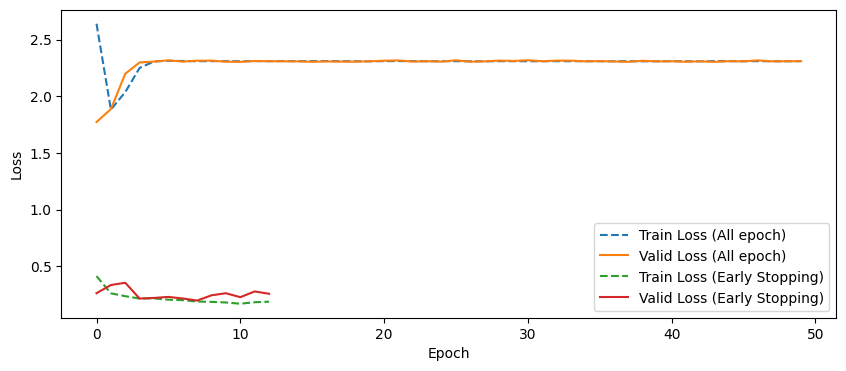

In [65]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss (All epoch)', linestyle='dashed')
plt.plot(val_losses, label='Valid Loss (All epoch)')
plt.plot(train_es_losses, label='Train Loss (Early Stopping)', linestyle = 'dashed')
plt.plot(val_es_losses, label='Valid Loss (Early Stopping)')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### L2 적용

In [71]:
def train_reg(model, train_loader, val_loader, optimizer, epochs=50):
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    val_losses = []
    weight_norms = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0 
        for images, labels in train_loader :
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad() :
            for images, labels in val_loader :
                images = images.view(images.size(0), -1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim =1)
                correct += (preds == labels).sum().item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        accuracy = correct / len(val_data)

        print(f'Epoch { epoch +1} | Val Loss : { val_loss:.4f}, Accuracy: { accuracy:.4f}')

        weight_norm = sum(torch.norm(p).item() for p in model.parameters())
        weight_norms.append(weight_norm)

    return train_losses, val_losses, weight_norms

In [ ]:
model_no_reg = RealSimpleNN()
optim_no_reg = optim.SGD(model_no_reg.parameters(), lr=0.01, weight_decay=0.0, momentum=0.9)              # weight_decay : 가중치 감쇄하는것 
train_losses, val_losses, weight_norms = train_reg(model_no_reg, train_loader, val_loader, optim_no_reg)

model_reg = RealSimpleNN()
optim_reg = optim.SGD(model_reg.parameters(), lr=0.01, weight_decay=0.01, momentum=0.9)
train_reg_losses, val_reg_losses, weight_norms_reg = train_reg(model_reg, train_loader, val_loader, optim_no_reg)

Epoch 1 | Val Loss : 0.2513, Accuracy: 0.9253
Epoch 2 | Val Loss : 0.1810, Accuracy: 0.9436
Epoch 3 | Val Loss : 0.1350, Accuracy: 0.9591
Epoch 4 | Val Loss : 0.1301, Accuracy: 0.9599
Epoch 5 | Val Loss : 0.1153, Accuracy: 0.9633
Epoch 6 | Val Loss : 0.1123, Accuracy: 0.9676
Epoch 7 | Val Loss : 0.1247, Accuracy: 0.9632
Epoch 8 | Val Loss : 0.1051, Accuracy: 0.9695
Epoch 9 | Val Loss : 0.0971, Accuracy: 0.9710
Epoch 10 | Val Loss : 0.0911, Accuracy: 0.9740
Epoch 11 | Val Loss : 0.0974, Accuracy: 0.9722
Epoch 12 | Val Loss : 0.1142, Accuracy: 0.9675
Epoch 13 | Val Loss : 0.0940, Accuracy: 0.9729
Epoch 14 | Val Loss : 0.1000, Accuracy: 0.9733
Epoch 15 | Val Loss : 0.0917, Accuracy: 0.9751
Epoch 16 | Val Loss : 0.0951, Accuracy: 0.9750
Epoch 17 | Val Loss : 0.0978, Accuracy: 0.9752
Epoch 18 | Val Loss : 0.1030, Accuracy: 0.9752
Epoch 19 | Val Loss : 0.1040, Accuracy: 0.9747
Epoch 20 | Val Loss : 0.1167, Accuracy: 0.9715
Epoch 21 | Val Loss : 0.0935, Accuracy: 0.9777
Epoch 22 | Val Loss : 

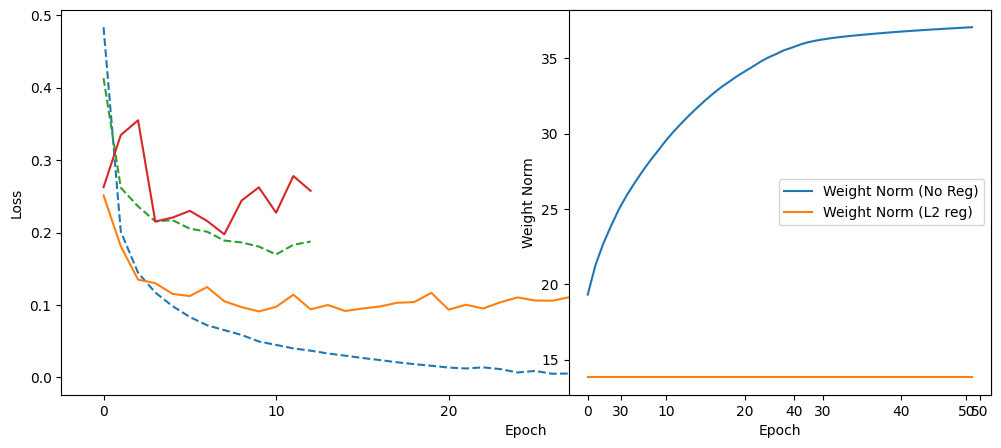

In [76]:
plt.figure(figsize=(12, 5))

plt.plot(train_losses, label='Train Loss (No Reg)', linestyle='dashed')
plt.plot(val_losses, label='Valid Loss (No Reg)')
plt.plot(train_es_losses, label='Train Loss (L2 reg)', linestyle = 'dashed')
plt.plot(val_es_losses, label='Valid Loss (L2 reg)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(weight_norms, label='Weight Norm (No Reg)')
plt.plot(weight_norms_reg, label='Weight Norm (L2 reg)')
plt.xlabel('Epoch')
plt.ylabel('Weight Norm')
plt.legend()

plt.show()